# Park a lot

## This notebook is put together by the following parts:  
1. A function to track cars in the video frames and save the car ids, frames, bounding boxes around the cars, and timestamp to a CSV file.

2. A function that uses the size of the bounding box to check when the car is closest to the camera, and checks if the frame numbers are counting upwards or downwards to figure out if the car is entering or exiting the parking lot. It stores the car as a variable "array_of_cars_found" containing: [direction, three image frames, timestamp].

3. A function that uses the variable "array_of_cars_found" where each of the images are sent into the EasyOCR model
 read license plates on each of the stored frames 

4. A csv file containing the parking times of the license plates and the size of the car.
5. An additional csv file containing the cars currently in the parking that will be checked against when a license plate apears on the camera.

This notebook contains all the functions nessecary to run the program, but jupyter notebook does not support multiprocessing. So to run the program we have to either run them separatly, or move the functionality into a separate .py file


In [ ]:
# Install requirements
# to run the code, the following are required, and should be installed in a new environment:

# create new environment
%conda create -n "park-3.9" python=3.9 ipython
# activate environment
%conda activate park-3.9
# install package
%conda install numpy
# install requirements.txt
%pip install -r requirements.txt --verbose
# install ipykernel
%conda install -n park-3.9 ipykernel --update-deps --force-reinstall
# install libraries that reads text from images
%pip install easyocr==1.6.2
%conda install pytesseract=0.3.10 -y

# Code that detects license plates:
# https://github.com/deepakat002/numberplaterecognition

# Model to read text from images: (best_submission.pt)
# Model to license plates: https://www.kaggle.com/code/priyammehta/license-plate-detection-using-yolov5/data
# the navigate to "yolo-models" -> "my-submission" -> "best_submission.pt"

In [1]:
# import libraries
import argparse
import os

# limit the number of cpus used by high performance libraries
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["VECLIB_MAXIMUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"

import sys
import time
# import csv
import glob
import pandas as pd
import numpy as np
from pathlib import Path
import torch
import torch.backends.cudnn as cudnn
from PIL import Image, ImageDraw, ImageFont

# from datetime import datetime

/opt/homebrew/Caskroom/miniforge/base/envs/park-3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import more libraries ++
ROOT = Path(os.getcwd()).resolve()  # yolov5 strongsort root directory
WEIGHTS = ROOT / 'weights'
directory_1 = os.getcwd()

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
if str(ROOT / 'yolov5') not in sys.path:
    sys.path.append(str(ROOT / 'yolov5'))  # add yolov5 ROOT to PATH
if str(ROOT / 'trackers' / 'strong_sort') not in sys.path:
    sys.path.append(str(ROOT / 'trackers' / 'strong_sort'))  # add strong_sort ROOT to PATH
if str(ROOT / 'trackers' / 'strong_sort' / 'sort') not in sys.path:
    sys.path.append(str(ROOT / 'trackers' / 'strong_sort' / 'sort'))  # add strong_sort ROOT to PATH

import logging
from yolov5.models.common import DetectMultiBackend
from yolov5.utils.dataloaders import VID_FORMATS, LoadImages, LoadStreams
from yolov5.utils.general import (LOGGER, check_img_size, non_max_suppression, scale_boxes, check_requirements, cv2,
                                  check_imshow, xyxy2xywh, increment_path, strip_optimizer, colorstr, print_args, check_file)
from yolov5.utils.torch_utils import select_device, time_sync
from yolov5.utils.plots import Annotator, colors, save_one_box
from trackers.multi_tracker_zoo import create_tracker

# set working directory to this file
os.chdir(ROOT)

directory_2 = os.getcwd()
assert directory_1 == directory_2, "Please check that working directory is set to this file"

In [3]:
# track and sort
@torch.no_grad()
def run(threshold_1=1,
        threshold_2=1,
        smallest_boundingbox_width=1,
        smallest_boundingbox_heigth=1,
        source='0',
        yolo_weights=WEIGHTS / 'yolov5m.pt',  # model.pt path(s),
        reid_weights=WEIGHTS / 'osnet_x0_25_msmt17.pt',  # model.pt path,
        tracking_method='strongsort',
        imgsz=(640, 640),  # inference size (height, width)
        conf_thres=0.25,  # confidence threshold
        iou_thres=0.45,  # NMS IOU threshold
        max_det=1000,  # maximum detections per image
        device='',  # cuda device, i.e. 0 or 0,1,2,3 or cpu
        show_vid=False,  # show results
        save_txt=False,  # save results to *.txt
        save_conf=False,  # save confidences in --save-txt labels
        save_crop=False,  # save cropped prediction boxes
        save_vid=False,  # save confidences in --save-txt labels
        nosave=False,  # do not save images/videos
        classes=None,  # filter by class: --class 0, or --class 0 2 3
        agnostic_nms=False,  # class-agnostic NMS
        augment=False,  # augmented inference
        visualize=False,  # visualize features
        update=False,  # update all models
        project=ROOT / 'runs/track',  # save results to project/name
        name='exp',  # save results to project/name
        exist_ok=False,  # existing project/name ok, do not increment
        line_thickness=2,  # bounding box thickness (pixels)
        hide_labels=False,  # hide labels
        hide_conf=False,  # hide confidences
        hide_class=False,  # hide IDs
        half=False,  # use FP16 half-precision inference
        dnn=False,  # use OpenCV DNN for ONNX inference
        vid_stride=1,  # video frame-rate stride
):

    source = str(source)
    save_img = not nosave and not source.endswith('.txt')  # save inference images
    is_file = Path(source).suffix[1:] in (VID_FORMATS)
    is_url = source.lower().startswith(('rtsp://', 'rtmp://', 'http://', 'https://'))
    webcam = source.isnumeric() or source.endswith('.txt') or (is_url and not is_file)
    if is_url and is_file:
        source = check_file(source)  # download

    # Directories
    if not isinstance(yolo_weights, list):  # single yolo model
        exp_name = yolo_weights.stem
    elif type(yolo_weights) is list and len(yolo_weights) == 1:  # single models after --yolo_weights
        exp_name = Path(yolo_weights[0]).stem
    else:  # multiple models after --yolo_weights
        exp_name = 'ensemble'
    exp_name = name if name else exp_name + "_" + reid_weights.stem
    save_dir = increment_path(Path(project) / exp_name, exist_ok=exist_ok)  # increment run
    (save_dir / 'tracks' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Load model
    device = select_device(device)
    model = DetectMultiBackend(yolo_weights, device=device, dnn=dnn, data=None, fp16=half)
    stride, names, pt = model.stride, model.names, model.pt
    imgsz = check_img_size(imgsz, s=stride)  # check image size

    # Dataloader
    if webcam:
        show_vid = check_imshow()
        dataset = LoadStreams(source, img_size=imgsz, stride=stride, auto=pt, vid_stride=vid_stride)
        nr_sources = len(dataset)
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt)
        nr_sources = 1
    vid_path, vid_writer, txt_path = [None] * nr_sources, [None] * nr_sources, [None] * nr_sources

    # Create as many strong sort instances as there are video sources
    tracker_list = []
    for i in range(nr_sources):
        tracker = create_tracker(tracking_method, reid_weights, device, half)
        tracker_list.append(tracker, )
        if hasattr(tracker_list[i], 'model'):
            if hasattr(tracker_list[i].model, 'warmup'):
                tracker_list[i].model.warmup()
    outputs = [None] * nr_sources
    # print(outputs)

    # Run tracking
    #model.warmup(imgsz=(1 if pt else nr_sources, 3, *imgsz))  # warmup
    dt, seen = [0.0, 0.0, 0.0, 0.0], 0
    curr_frames, prev_frames = [None] * nr_sources, [None] * nr_sources
    
    temp_array = ""
    extra_counter = 0
    
    for frame_idx, (path, im, im0s, vid_cap, s) in enumerate(dataset):
        if frame_idx % 5 != 0:
            continue
        extra_counter += 1
        t1 = time_sync()
        im = torch.from_numpy(im).to(device)
        im = im.half() if half else im.float()  # uint8 to fp16/32
        im /= 255.0  # 0 - 255 to 0.0 - 1.0
        if len(im.shape) == 3:
            im = im[None]  # expand for batch dim
        t2 = time_sync()
        dt[0] += t2 - t1

        # Inference
        visualize = increment_path(save_dir / Path(path[0]).stem, mkdir=True) if visualize else False
        pred = model(im, augment=augment, visualize=visualize)
        t3 = time_sync()
        dt[1] += t3 - t2

        # Apply NMS
        pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
        dt[2] += time_sync() - t3

        
        # Process detections
        for i, det in enumerate(pred):  # detections per image
            seen += 1
            if webcam:  # nr_sources >= 1
                p, im0, _ = path[i], im0s[i].copy(), dataset.count
                p = Path(p)  # to Path
                s += f'{i}: '
                txt_file_name = p.name
                save_path = str(save_dir / p.name)  # im.jpg, vid.mp4, ...
            else:
                p, im0, _ = path, im0s.copy(), getattr(dataset, 'frame', 0)
                p = Path(p)  # to Path
                # video file
                if source.endswith(VID_FORMATS):
                    txt_file_name = p.stem
                    save_path = str(save_dir / p.name)  # im.jpg, vid.mp4, ...
                # folder with imgs
                else:
                    txt_file_name = p.parent.name  # get folder name containing current img
                    save_path = str(save_dir / p.parent.name)  # im.jpg, vid.mp4, ...
            curr_frames[i] = im0

            txt_path = str(save_dir / 'tracks' / 'intermediate_storage')  # im.txt
            s += '%gx%g ' % im.shape[2:]  # print string
            imc = im0.copy() if save_crop else im0  # for save_crop

            annotator = Annotator(im0, line_width=line_thickness, example=str(names))
            
            if hasattr(tracker_list[i], 'tracker') and hasattr(tracker_list[i].tracker, 'camera_update'):
                if prev_frames[i] is not None and curr_frames[i] is not None:  # camera motion compensation
                    tracker_list[i].tracker.camera_update(prev_frames[i], curr_frames[i])

            if det is not None and len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()  # xyxy

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # pass detections to strongsort
                t4 = time_sync()
                outputs[i] = tracker_list[i].update(det.cpu(), im0)
                t5 = time_sync()
                dt[3] += t5 - t4

                # draw boxes for visualization
                if len(outputs[i]) > 0:
                    for j, (output, conf) in enumerate(zip(outputs[i], det[:, 4])):


                    # ------------------------------------------------------ SAVE TO FILE  ----------------------------------------------------------
                        bbox_top = output[1]
                        bbox_w = output[2] - output[0]
                        bbox_h = output[3] - output[1]

                        cv2.line(im0, (0, threshold_1), (im0.shape[1], threshold_1), (255, 0, 0), 2) # Blue
                        cv2.line(im0, (0, threshold_2), (im0.shape[1], threshold_2), (255, 0, 0), 2) # Blue

                        if (bbox_top+bbox_h < threshold_1) and (bbox_top+bbox_h > threshold_2) and(bbox_w > smallest_boundingbox_width) and (bbox_h > smallest_boundingbox_heigth):
                            cv2.imwrite(str(save_dir)+"/frame id_"+str(frame_idx+1)+".jpg", im0)


                            bboxes = output[0:4]
                            id = output[4]
                            cls = output[5]
                            if save_txt:
                                # to MOT format
                                bbox_left = output[0]
                                # append to string

                                # add info to array
                                temp_array += f'{frame_idx + 1},{id},{bbox_left},{bbox_top},{bbox_w},{bbox_h},{time.time()}\n'
                            
                                if extra_counter % 5 == 0:
                                    # Write MOT compliant results to file
                                    with open(txt_path + '.csv', 'a') as f:
                                        f.write(temp_array)
                                        f.close()
                                        temp_array = ""

                            if save_vid or save_crop or show_vid:  # Add bbox to image
                                c = int(cls)  # integer class
                                id = int(id)  # integer id
                                label = None if hide_labels else (f'{id} {names[c]}' if hide_conf else \
                                    (f'{id} {conf:.2f}' if hide_class else f'{id} {names[c]} {conf:.2f}'))
                                annotator.box_label(bboxes, label, color=colors(c, True))
                                if save_crop:
                                    txt_file_name = txt_file_name if (isinstance(path, list) and len(path) > 1) else ''
                                    save_one_box(bboxes, imc, file=save_dir / 'crops' / txt_file_name / names[c] / f'{id}' / f'{p.stem}.jpg', BGR=True)

                # LOGGER.info(f'{s}Done. yolo:({t3 - t2:.3f}s), {tracking_method}:({t5 - t4:.3f}s)')

            # else:
                #strongsort_list[i].increment_ages()
                # LOGGER.info('No detections')          

            # Stream results
            im0 = annotator.result()
            if show_vid:
                cv2.imshow(str(p), im0)
                cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if save_vid:
                if vid_path[i] != save_path:  # new video
                    vid_path[i] = save_path
                    if isinstance(vid_writer[i], cv2.VideoWriter):
                        vid_writer[i].release()  # release previous video writer
                    if vid_cap:  # video
                        fps = vid_cap.get(cv2.CAP_PROP_FPS)
                        w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                        h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                    else:  # stream
                        fps, w, h = 30, im0.shape[1], im0.shape[0]
                    save_path = str(Path(save_path).with_suffix('.mp4'))  # force *.mp4 suffix on results videos
                    vid_writer[i] = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                vid_writer[i].write(im0)

            prev_frames[i] = curr_frames[i]

    # Print results
    # t = tuple(x / seen * 1E3 for x in dt)  # speeds per image
    # LOGGER.info(f'Speed: %.1fms pre-process, %.1fms inference, %.1fms NMS, %.1fms {tracking_method} update per image at shape {(1, 3, *imgsz)}' % t)
    # if save_txt or save_vid:
        # s = f"\n{len(list(save_dir.glob('tracks/*.txt')))} tracks saved to {save_dir / 'tracks'}" if save_txt else ''
        # LOGGER.info(f"Results saved to {colorstr('bold', save_dir)}{s}")
    if update:
        strip_optimizer(yolo_weights)  # update model (to fix SourceChangeWarning)


In [4]:
# set arguments for the track and sort function
def parse_opt(video_path):
    parser = argparse.ArgumentParser()
    parser.add_argument('--yolo-weights', nargs='+', type=Path, default=WEIGHTS / 'yolov5n.pt', help='model.pt path(s)')
    parser.add_argument('--reid-weights', type=Path, default=WEIGHTS / 'osnet_x0_25_msmt17.pt')
    parser.add_argument('--tracking-method', type=str, default='strongsort', help='strongsort, ocsort, bytetrack')
    parser.add_argument('--source', type=str, default='0', help='file/dir/URL/glob, 0 for webcam')  
    parser.add_argument('--imgsz', '--img', '--img-size', nargs='+', type=int, default=[640], help='inference size h,w')
    parser.add_argument('--conf-thres', type=float, default=0.5, help='confidence threshold')
    parser.add_argument('--iou-thres', type=float, default=0.5, help='NMS IoU threshold')
    parser.add_argument('--max-det', type=int, default=1000, help='maximum detections per image')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--show-vid', action='store_true', help='display tracking video results')
    parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
    parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
    parser.add_argument('--save-crop', action='store_true', help='save cropped prediction boxes')
    parser.add_argument('--save-vid', action='store_true', help='save video tracking results')
    parser.add_argument('--nosave', action='store_true', help='do not save images/videos')
    # class 0 is person, 1 is bycicle, 2 is car... 79 is oven
    parser.add_argument('--classes', nargs='+', type=int, help='filter by class: --classes 0, or --classes 0 2 3')
    parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
    parser.add_argument('--augment', action='store_true', help='augmented inference')
    parser.add_argument('--visualize', action='store_true', help='visualize features')
    parser.add_argument('--update', action='store_true', help='update all models')
    parser.add_argument('--project', default=ROOT / 'runs/track', help='save results to project/name')
    parser.add_argument('--name', default='exp', help='save results to project/name')
    # parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--line-thickness', default=2, type=int, help='bounding box thickness (pixels)')
    parser.add_argument('--hide-labels', default=False, action='store_true', help='hide labels')
    parser.add_argument('--hide-conf', default=False, action='store_true', help='hide confidences')
    parser.add_argument('--hide-class', default=False, action='store_true', help='hide IDs')
    parser.add_argument('--half', action='store_true', help='use FP16 half-precision inference')
    parser.add_argument('--dnn', action='store_true', help='use OpenCV DNN for ONNX inference')
    parser.add_argument('--vid-stride', type=int, default=1, help='video frame-rate stride')

    opt = parser.parse_args(['--source', video_path,
                             '--classes', '2',
                             '--save-txt'
                             ,'--show-vid'
                             ])

    opt.imgsz *= 2 if len(opt.imgsz) == 1 else 1  # expand
    print_args(vars(opt))
    return opt


In [5]:
# Run the track and sort function on the video specified here !!!! ---
def track_cars(video_path, threshold_1,threshold_2, smallest_boundingbox_w, smallest_boundingbox_h):
    print(os.getcwd())
    # set path to video
    opt = parse_opt(video_path)
    # check_requirements(requirements=ROOT / 'requirements.txt', exclude=('tensorboard', 'thop'))
    width = int(cv2.VideoCapture(video_path).get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cv2.VideoCapture(video_path).get(cv2.CAP_PROP_FRAME_HEIGHT))
    run(**vars(opt), threshold_1=int(height*threshold_1), threshold_2=int(height*threshold_2), smallest_boundingbox_width=smallest_boundingbox_w, smallest_boundingbox_heigth=smallest_boundingbox_h, exist_ok=True)
    return width, height

# enter threshold values here`
frame_width, frame_height = track_cars(video_path='IMG_0346.mp4', threshold_1=0.98, threshold_2=0.75, smallest_boundingbox_w=150, smallest_boundingbox_h=150)
# print("frame_width:",frame_width)
# print("frame_height:",frame_height)

124629129: yolo_weights=/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/UiA/ikt452_comp_vis/park-it/weights/yolov5n.pt, reid_weights=/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/UiA/ikt452_comp_vis/park-it/weights/osnet_x0_25_msmt17.pt, tracking_method=strongsort, source=IMG_0346.mp4, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.5, max_det=1000, device=, show_vid=True, save_txt=True, save_conf=False, save_crop=False, save_vid=False, nosave=False, classes=[2], agnostic_nms=False, augment=False, visualize=False, update=False, project=/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/UiA/ikt452_comp_vis/park-it/runs/track, name=exp, line_thickness=2, hide_labels=False, hide_conf=False, hide_class=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2022-12-2 Python-3.9.15 torch-1.13.0 CPU

Fusing layers... 


/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/UiA/ikt452_comp_vis/park-it


YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients


Successfully loaded pretrained weights from "/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/UiA/ikt452_comp_vis/park-it/weights/osnet_x0_25_msmt17.pt"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


The array returned from the function is returning the three larges images in frame of that object,       
 and a boolean value if the car is entering or leaving:

Car entering = True


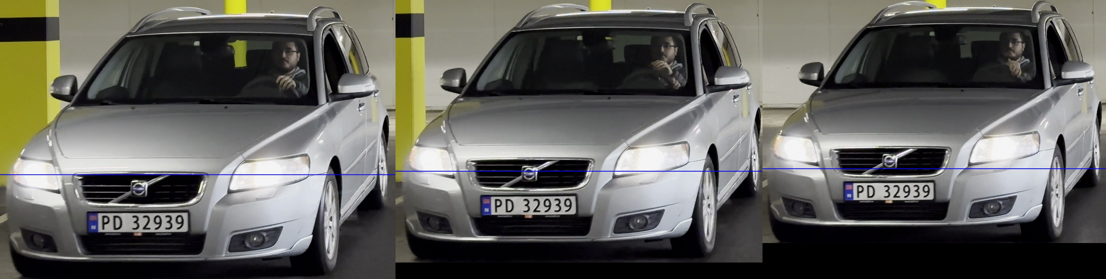

Car entering = False


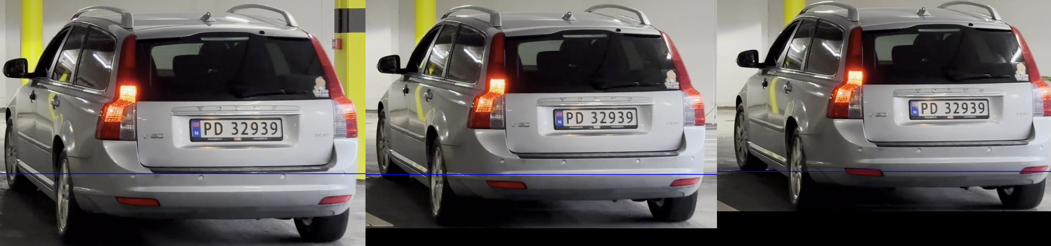

In [6]:
from fetching.fetch_car_functions import *
array_of_cars_found = fetch_cars(required_log_entries_per_car=5, frame_width=3840, delete_cars=True)

# show the cars found
print("The array returned from the function is returning the three larges images in frame of that object, \
      \n and a boolean value if the car is entering or leaving:\n")
for each in array_of_cars_found:
    if each[0] == True:
        print("Car entering = True")
    else:
        print("Car entering = False")

    img1 = np.array(each[1][0])
    img2 = np.array(each[1][1])
    img3 = np.array(each[1][2])

    # create a new image with the size of the images
    new_im = Image.new('RGB', (img1.shape[1] + img2.shape[1] + img3.shape[1], img1.shape[0]))

    # paste the images into the new image
    new_im.paste(Image.fromarray(cv2.cvtColor(np.array(each[1][0]), cv2.COLOR_BGR2RGB)), (0,0))
    new_im.paste(Image.fromarray(cv2.cvtColor(np.array(each[1][1]), cv2.COLOR_BGR2RGB)), (img1.shape[1],0))
    new_im.paste(Image.fromarray(cv2.cvtColor(np.array(each[1][2]), cv2.COLOR_BGR2RGB)), (img1.shape[1] + img2.shape[1],0))

    # make the new_im half the size
    new_im = new_im.resize((int(new_im.size[0]/4), int(new_im.size[1]/4)))
    display(new_im)



CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
YOLOv5 🚀 2022-12-2 Python-3.9.15 torch-1.13.0 CPU

Fusing layers... 
YOLOv5s summary: 232 layers, 7246518 parameters, 0 gradients
Adding AutoShape... 


Text prediction using EasyOCR:  PD 32939
Text prediction using EasyOCR:  PD 32939
Text prediction using EasyOCR:  PD 32939
detected_license_plate:  PD32939
the car with license plate PD32939 driving in
  Plate Number        Date and time
0      PD32939  05/12/2022 22:57:45
Number of available parking spots:  49


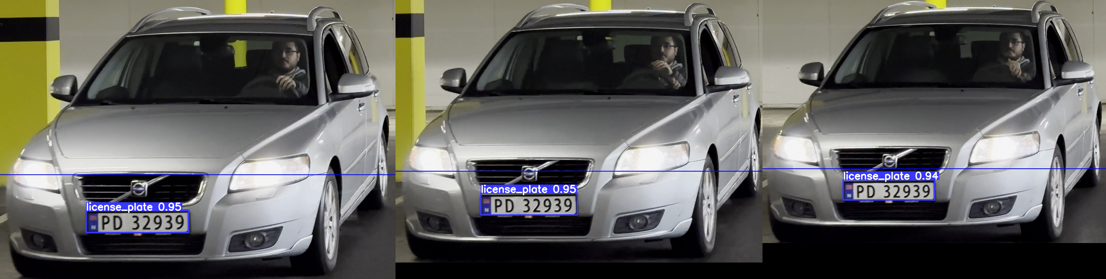

Text prediction using EasyOCR:  PD 32939
Text prediction using EasyOCR:  PD 32939
Text prediction using EasyOCR:  PD32939
detected_license_plate:  PD32939
the car with license plate PD32939 driving out
  Plate Number        Drive in time       Drive out time Duration
0      PD32939  05/12/2022 22:39:13  05/12/2022 22:39:43  0:00:30
1      PD32939  05/12/2022 22:39:13  05/12/2022 22:39:43  0:00:30
2      PD32939  05/12/2022 22:53:50  05/12/2022 22:54:19  0:00:29
3      PD32939  05/12/2022 22:57:45  05/12/2022 22:58:15  0:00:30


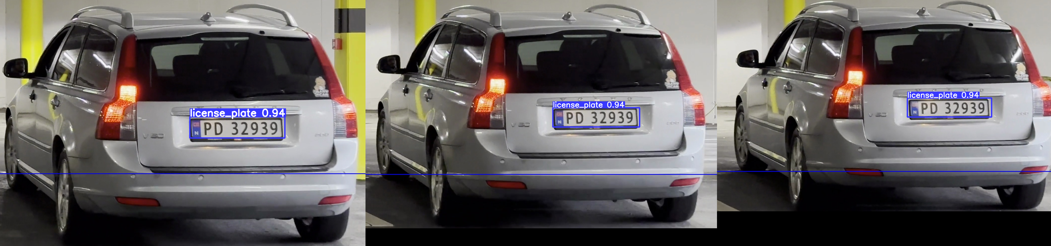

: 

In [7]:
from fetching.detect_license_plate_functions import *
assert array_of_cars_found is not None, "No cars found, please run the function called 'fetch_cars(...)' first"
model = torch.hub.load('./yolov5', 'custom', source='local', path='weights/best_submission.pt', force_reload=True)

number_of_cars = 0
for each_car in array_of_cars_found:
    results = detect_and_log_cars(each_car, model)
    # print the results images
    # for each in range(3):
        # display(Image.fromarray(results[each].render()[0]))

        # if each[0] == True:
        #     print("Car entering = True")
        # else:
        #     print("Car entering = False")

    img1 = results[0].render()[0]
    img2 = results[1].render()[0]
    img3 = results[2].render()[0]

    # create a new image with the size of the images
    new_im = Image.new('RGB', (img1.shape[1] + img2.shape[1] + img3.shape[1], img1.shape[0]))

    # paste the images into the new image

    new_im.paste(Image.fromarray(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)), (0,0))
    new_im.paste(Image.fromarray(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)), (img1.shape[1],0))
    new_im.paste(Image.fromarray(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)), (img1.shape[1] + img2.shape[1],0))
    # make the new_im half the size
    new_im = new_im.resize((int(new_im.size[0]/4), int(new_im.size[1]/4)))
    display(new_im)

    

